# IEEE Fraud Detection Kaggle Competition
## LightGBM V feats feature engineering

After playing around with V features (dropping them, encoding groups of them), a better validation score was obtained accidentally when V138-V339 were dropped in place of a "HasVfeats" feature that was a binary variable encoding for whether all of V138-V339 were missing.

This improved score on validation set from 0.98206 -> 0.982339 and didn't find HasVfeats important at all (no splits).

Removing all V features (V1-V339) led to a reduction in score from 0.98206 -> 0.97735

Looking at the most important V features from lightgbm_card1_count_encoded.ipynb, the following were the 40th - 50th most important in descending order

- V313	460
- M9	449
- M7	376
- M3	355
- V307	349
- D6	328
- C5	309
- V315	302
- V310	301
- D12	291
- V83	277

In this notebook, we explore, the top V feaures as per above, try to figure out why dropping them improves the model,  infer what they are and get some insight into why they are grouped together

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

num_folds = 5
SEED = 5000

# Load and prepare data

In [3]:
train = pd.read_csv('../output/train_card1_count.csv')
test = pd.read_csv('../output/test_card1_count.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [4]:
val_indices = np.load('../output/val_indices.npy')

In [5]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_count
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.

In [6]:
print(train.shape)

(590540, 435)


In [7]:
print(test.shape)

(506691, 434)


In [8]:
# Lightgbm parameters from https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt
params = {
        'bagging_fraction': 0.8999999999997461,
        'feature_fraction': 0.8999999999999121,
        'max_depth': int(50.0),
        'min_child_weight': 0.0029805017044362268,
        'min_data_in_leaf': int(20.0),
        'num_leaves': int(381.85354295079446),
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'objective': 'binary',
        'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

early_rounds = 50
num_iterations = 300

In [9]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [10]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

# V313

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'V313 distribution')

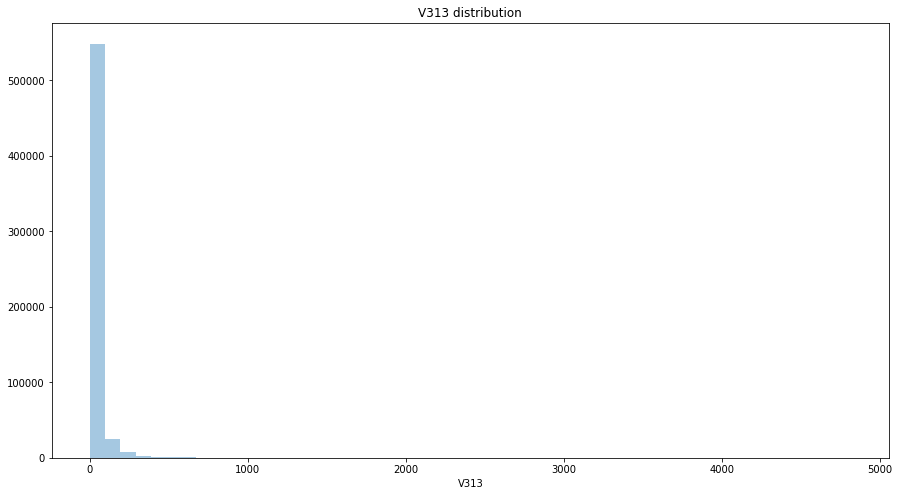

In [11]:
plt.figure(figsize=(15,8))
sns.distplot(train['V313'], kde=False)
plt.title('V313 distribution')

In [12]:
train['V313'].value_counts()

0.000000       489641
59.000000        6654
117.000000       5319
57.950001        3608
107.949997       3472
49.000000        3096
226.000000       2368
39.000000        2331
100.000000       2186
29.000000        1666
47.950001        1530
34.000000        1485
35.950001        1483
171.000000       1423
77.000000        1401
25.950001        1389
30.950001        1130
58.950001         965
67.949997         882
209.949997        873
97.000000         872
335.000000        852
50.000000         850
92.000000         806
108.949997        772
108.500000        761
54.500000         592
159.949997        578
87.000000         550
141.000000        519
82.949997         502
36.950001         484
54.000000         470
25.000000         469
554.000000        435
445.000000        420
280.000000        401
44.000000         392
48.950001         377
15.000000         373
311.950012        363
87.949997         361
40.000000         350
26.950001         346
77.949997         327
150.000000

Continuous feature - does it correlate with any of our other variables?

In [13]:
correlations = train.corr()

In [14]:
correlations

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,card1_count
TransactionID,1.000000,0.014166,0.998280,0.012025,-0.027043,-0.026273,-0.053154,-0.055186,-0.008896,-0.057235,0.024444,-0.050376,-0.059485,-0.060490,0.033460,-0.062073,-0.054122,-0.058796,-0.017455,-0.043123,0.074338,0.026477,-0.006997,0.058633,0.002053,0.081941,-0.071569,-0.071505,-0.015457,0.056533,0.100242,0.052536,0.023352,0.095742,0.071285,0.001609,0.043721,0.044101,0.036061,0.033277,0.037936,0.037899,0.036606,0.035126,0.012900,0.015073,0.095513,0.093682,-0.003049,-0.027305,-0.030358,-0.018493,-0.020758,0.012811,0.004417,-0.018802,-0.017885,-0.001733,-0.001529,0.008267,0.001800,-0.006796,-0.004716,0.013342,0.014974,-0.030654,-0.033514,-0.011654,0.001312,0.122415,0.119793,-0.011573,-0.003462,-0.054059,-0.045949,-0.001940,-0.060570,-0.050184,-0.006123,-0.003488,-0.022559,-0.020398,0.033435,0.033073,-0.073398,-0.035869,-0.025255,0.109545,0.106413,0.005278,0.021741,-0.039267,-0.031172,-0.022812,-0.015934,0.015731,0.014385,-0.023153,-0.012838,-0.003834,0.005375,0.006396,-0.003225,0.014323,0.015880,-0.035108,-0.027716,-0.022403,-0.007149,0.101272,0.098428,-0.002823,0.017021,-0.029226,-0.043141,-0.033431,0.009284,0.008316,-0.045756,-0.028955,-0.000726,0.003122,-0.002153,-0.004515,0.022317,0.022916,-0.054259,-0.044316,-0.024978,0.059641,0.066849,0.067562,0.018179,0.075549,0.064023,0.058758,0.062462,0.065413,0.061837,0.071223,0.071692,-0.022165,0.004815,0.030843,0.015882,-0.005594,0.008128,-0.001196,0.014165,0.051740,0.028589,-0.011014,0.006492,-0.005405,-0.007017,0.019939,0.004401,0.009696,0.058098,0.038253,0.058853,0.066398,0.066591,0.004234,0.067183,0.041028,0.058108,0.061456,0.064225,0.019901,0.058545,0.044327,-0.007022,0.038760,0.044782,0.022475,0.037229,0.157087,-0.248605,-0.273548,0.061851,0.059484,0.042271,0.042437,-0.306317,-0.303988,-0.237093,0.039431,0.041361,0.041873,0.041688,0.050565,0.051548,-0.302742,-0.282572,-0.014603,0.003533,-0.010569,0.167661,0.064338,-0.154957,0.135566,0.146449,0.016365,0.039247,0.137835,-0.023858,-0.012754,0.090709,0.163273,0.018667,0.134468,0.143376,0.148628,0.135153,0.150156,0.145648,0.155519,0.029863,0.101542,-0.014485,-0.034959,0.026353,0.033944,0.001586,-0.030966,-0.033628,-0.037399,-0.031173,-0.

In [15]:
correlations['V313'].sort_values(ascending=False).head()

V313    1.000000
V315    0.918433
V314    0.749145
V288    0.513608
V208    0.505646
Name: V313, dtype: float64

High correlation between V313 and V314 and V315. Decent correlation with TransactionAmt also. Maybe be linearly dependent. Let's remove V313 and see if performance improves. 

In [16]:
correlations['V313'].sort_values()['isFraud']

0.041494252909127886

Text(0.5, 1.0, 'V315 distribution')

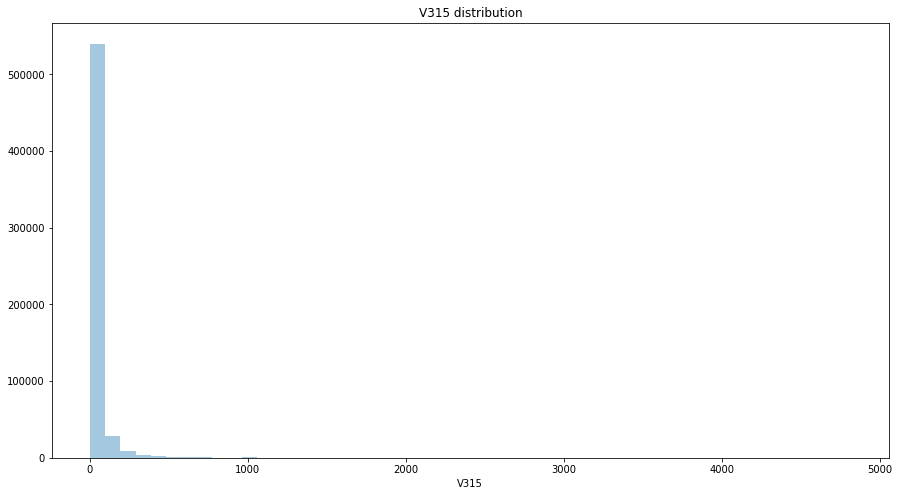

In [17]:
plt.figure(figsize=(15,8))
sns.distplot(train['V315'], kde=False)
plt.title('V315 distribution')

Text(0.5, 1.0, 'V315 vs. V313')

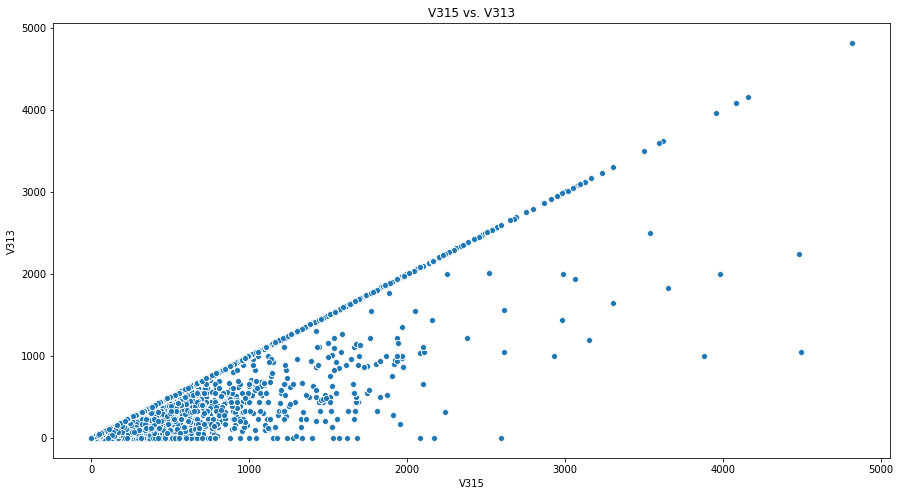

In [18]:
plt.figure(figsize=(15,8))
sns.scatterplot('V315', 'V313', data=train)
plt.title('V315 vs. V313')

V313 <= V315 for all points - it would make sense to remove V313 in this case as there is likely nothing that V313 can tell the model that V315 doesn't

Text(0.5, 1.0, 'V314 vs. V313')

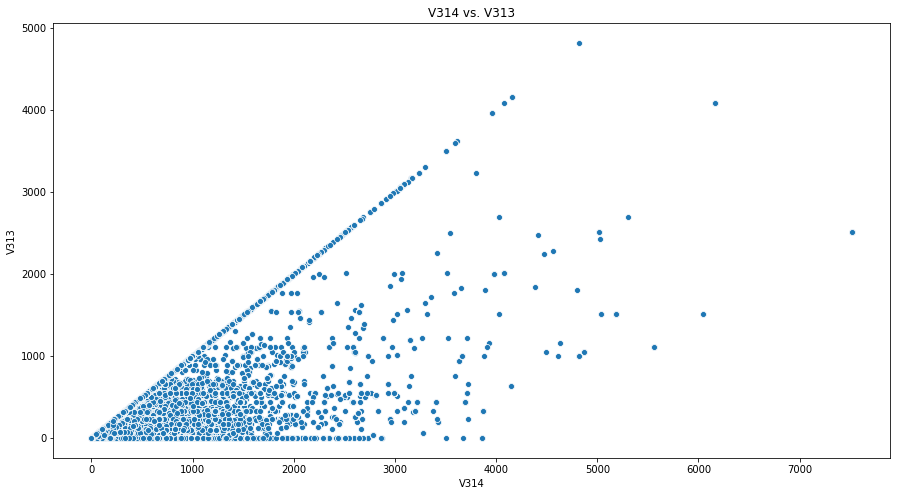

In [19]:
plt.figure(figsize=(15,8))
sns.scatterplot('V314', 'V313', data=train)
plt.title('V314 vs. V313')

Same again here. V313<=V314

Text(0.5, 1.0, 'V288 vs. V313')

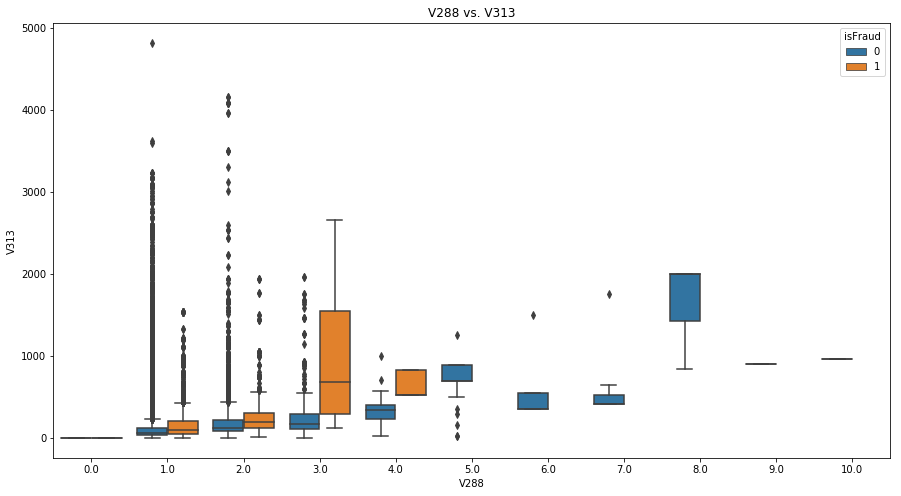

In [20]:
plt.figure(figsize=(15,8))
sns.boxplot('V288', 'V313', hue='isFraud', data=train)
plt.title('V288 vs. V313')

Having a value of 3 for V288 and a value above approximately 200 for V313 seems to be a decent indicator for fraud. As is having a value of 4 for V288 and a value above approximately 6/700 for V313. Of course, this plot looks extremely similar to the ones generated with V314 and V315 due to high correlation between features.

Text(0.5, 1.0, 'V288 vs. V314')

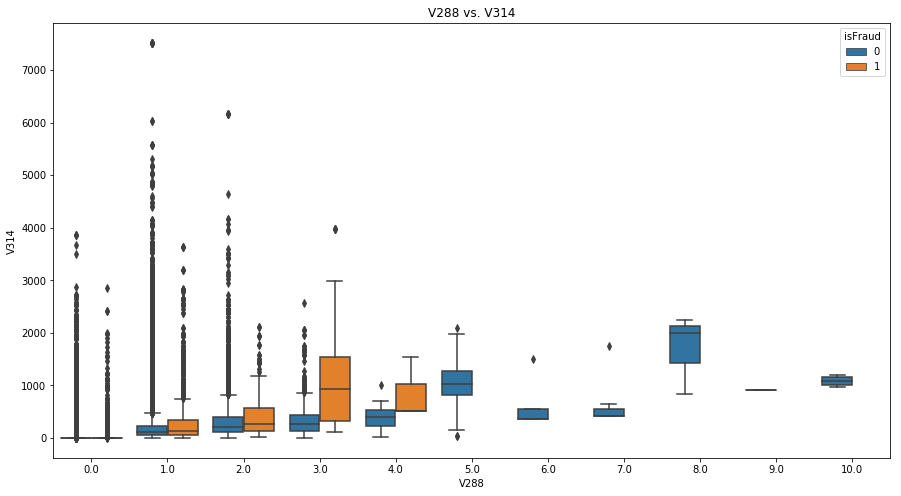

In [21]:
plt.figure(figsize=(15,8))
sns.boxplot('V288', 'V314', hue='isFraud', data=train)
plt.title('V288 vs. V314')

Text(0.5, 1.0, 'V288 vs. V315')

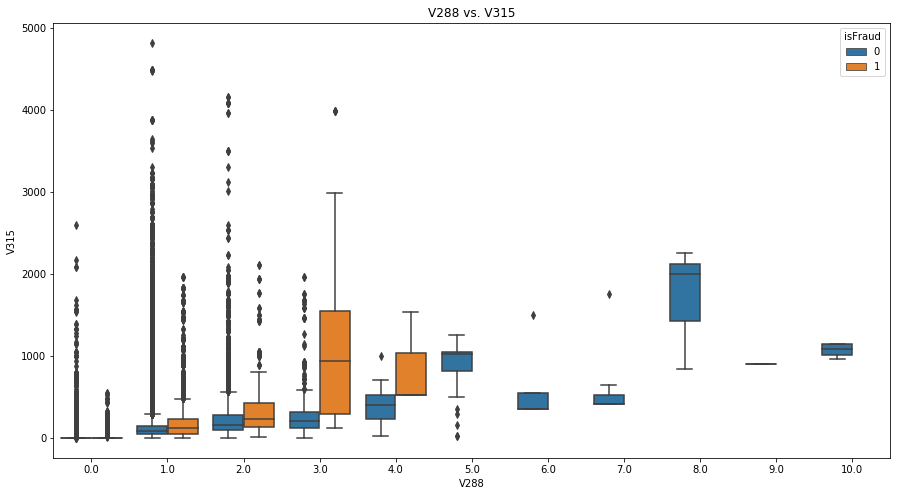

In [22]:
plt.figure(figsize=(15,8))
sns.boxplot('V288', 'V315', hue='isFraud', data=train)
plt.title('V288 vs. V315')

Text(0.5, 1.0, 'V288 vs. isFraud')

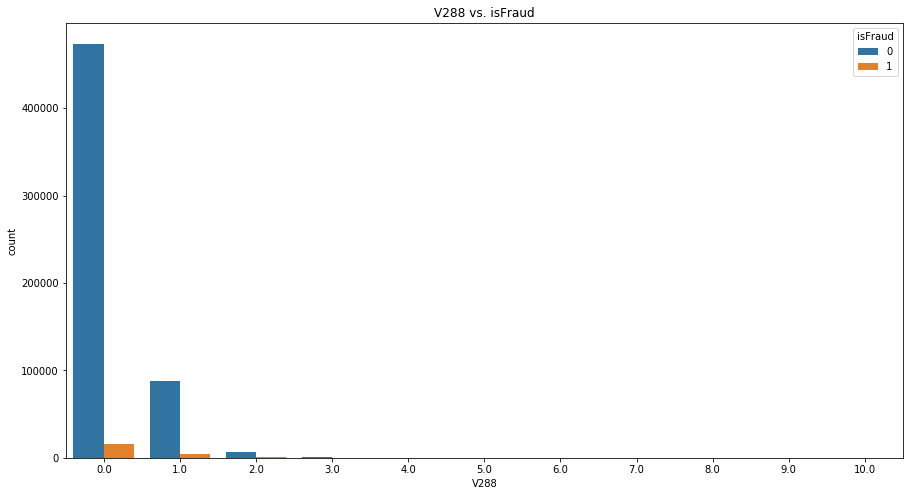

In [23]:
plt.figure(figsize=(15,8))
sns.countplot('V288', hue='isFraud', data=train)
plt.title('V288 vs. isFraud')

V288 doesn't look incredibly useful from this plot but its combination with the above features can be useful. 

Text(0.5, 1.0, 'V314 vs. V315')

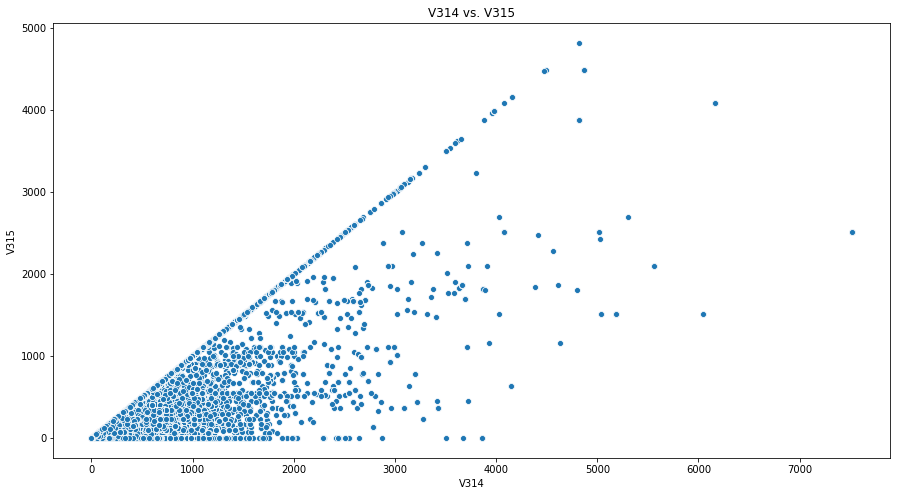

In [24]:
plt.figure(figsize=(15,8))
sns.scatterplot('V314', 'V315', data=train)
plt.title('V314 vs. V315')

In [25]:
correlations['V313'].sort_values(ascending=False).head().index.tolist()

['V313', 'V315', 'V314', 'V288', 'V208']

<Figure size 432x288 with 0 Axes>

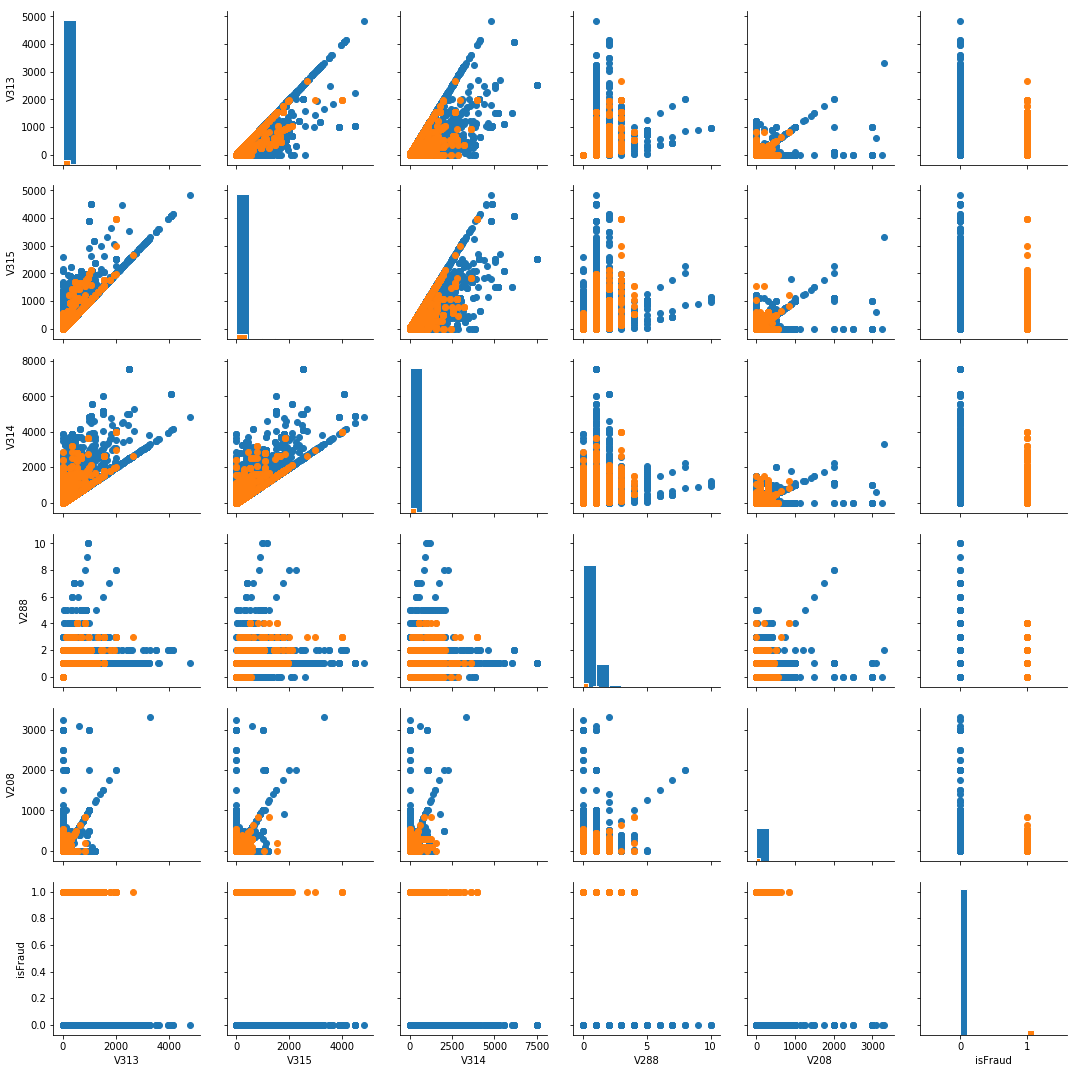

In [26]:
plt.figure()
g = sns.PairGrid(train.loc[:,correlations['V313'].sort_values(ascending=False).head().index.tolist() + ["isFraud"]], hue="isFraud")
g = g.map_offdiag(plt.scatter)
# g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist, edgecolor="w")
plt.show()

In [27]:
train[['V313', 'V314', 'V315', 'TransactionAmt']].head(40)

,V313,V314,V315,TransactionAmt
0,0.000000,0.000000,0.000000,68.500
1,0.000000,0.000000,0.000000,29.000
2,0.000000,0.000000,0.000000,59.000
3,0.000000,0.000000,0.000000,50.000
4,0.000000,0.000000,0.000000,50.000
5,0.000000,0.000000,0.000000,49.000
6,0.000000,0.000000,0.000000,159.000
7,0.000000,0.000000,0.000000,422.500
8,0.000000,0.000000,0.000000,15.000
9,0.000000,495.000000,0.000000,117.000


V313 and V315 both cannot be a higher value than V314

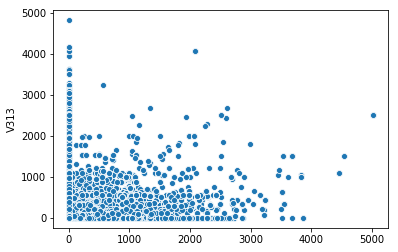

In [28]:
plt.figure()
sns.scatterplot(train['V314'] - train['V313'], train['V313'])

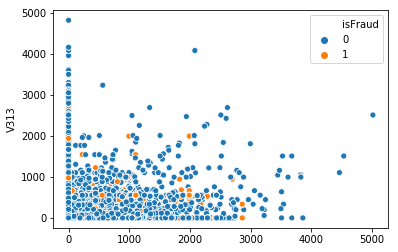

In [29]:
plt.figure()
sns.scatterplot(train['V314'] - train['V313'], 'V313', data=train, hue='isFraud')

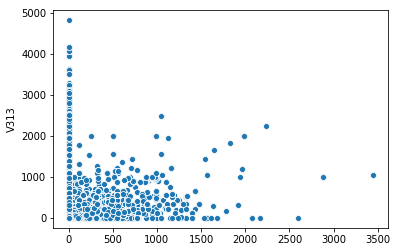

In [30]:
plt.figure()
sns.scatterplot(train['V315'] - train['V313'], train['V313'])

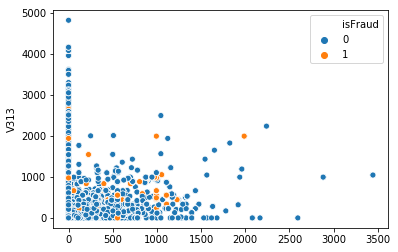

In [31]:
plt.figure()
sns.scatterplot(train['V315'] - train['V313'], 'V313', data=train, hue='isFraud')

In [32]:
pd.concat([train[['V313', 'V314', 'V315', 'TransactionAmt']], train['V314']-train['V313'],
           train['V314']-train['V315'],  train['V314']-train['TransactionAmt']], axis=1)

,V313,V314,V315,TransactionAmt,0,1,2
0,0.000000,0.000000,0.000000,68.500,0.000000,0.000000,-68.500000
1,0.000000,0.000000,0.000000,29.000,0.000000,0.000000,-29.000000
2,0.000000,0.000000,0.000000,59.000,0.000000,0.000000,-59.000000
3,0.000000,0.000000,0.000000,50.000,0.000000,0.000000,-50.000000
4,0.000000,0.000000,0.000000,50.000,0.000000,0.000000,-50.000000
5,0.000000,0.000000,0.000000,49.000,0.000000,0.000000,-49.000000
6,0.000000,0.000000,0.000000,159.000,0.000000,0.000000,-159.000000
7,0.000000,0.000000,0.000000,422.500,0.000000,0.000000,-422.500000
8,0.000000,0.000000,0.000000,15.000,0.000000,0.000000,-15.000000
9,0.000000,495.000000,0.000000,117.000,495.000000,495.000000,378.000000


V313 <= V315 <= V314

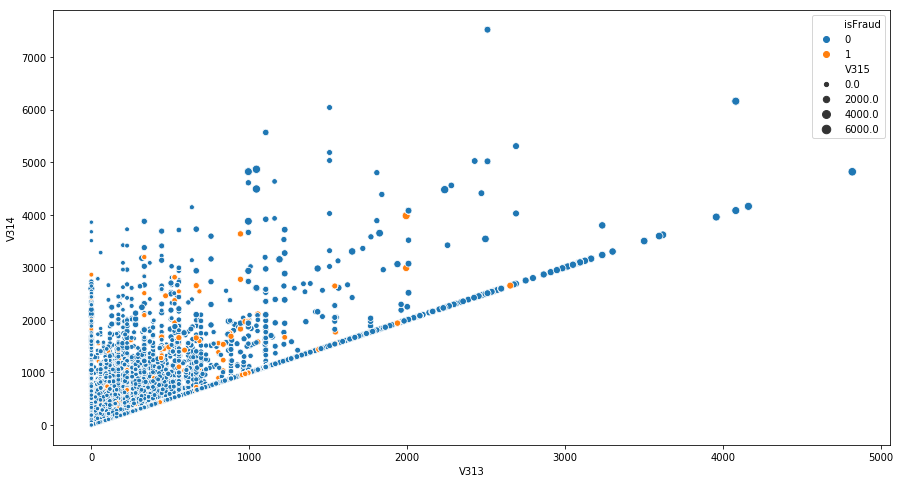

In [33]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='V313', y='V314', size='V315', hue='isFraud', data=train)

V314 and V313 are upper and lower limits respectively for V315 => V315-V313 and V314-V315 maybe be useful min/max delta features?

In [34]:
pd.concat([train[['V313', 'V314', 'V315']], train['V315']-train['V313'],
           train['V314']-train['V315']], axis=1)

,V313,V314,V315,0,1
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,495.000000,0.000000,0.000000,495.000000


Text(0, 0.5, 'V315-V313')

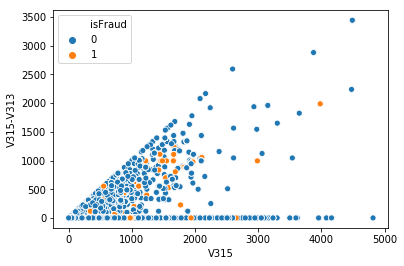

In [35]:
plt.figure()
sns.scatterplot(y=train['V315'] - train['V313'], x='V315', data=train, hue='isFraud')
plt.ylabel('V315-V313')

Text(0, 0.5, 'V314-V315')

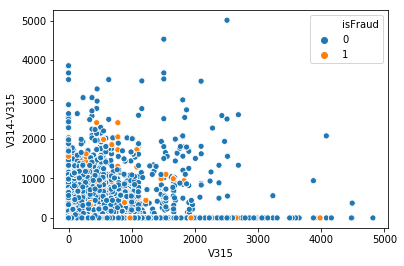

In [36]:
plt.figure()
sns.scatterplot(y=train['V314'] - train['V315'], x='V315', data=train, hue='isFraud')
plt.ylabel('V314-V315')

# Looking at distributions of features across train, val, and test

<Figure size 432x288 with 0 Axes>

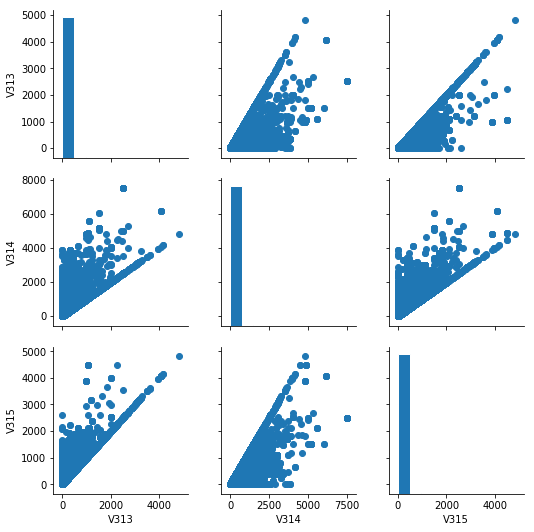

In [37]:
plt.figure()
g = sns.PairGrid(train.loc[:,['V313', 'V314', 'V315']])
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist, edgecolor="w")
plt.show()

<Figure size 432x288 with 0 Axes>

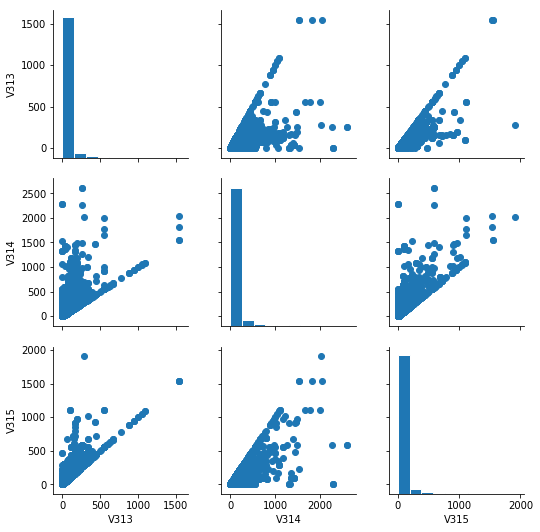

In [38]:
plt.figure()
g = sns.PairGrid(train.iloc[val_indices][['V313', 'V314', 'V315']])
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist, edgecolor="w")
plt.show()

<Figure size 432x288 with 0 Axes>

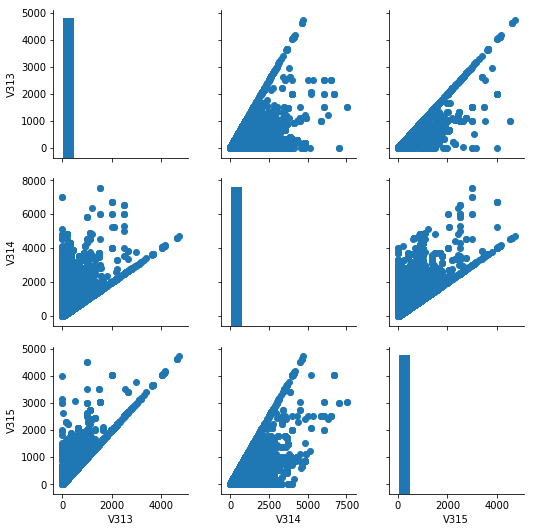

In [39]:
plt.figure()
g = sns.PairGrid(test.loc[:, ['V313', 'V314', 'V315']])
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist, edgecolor="w")
plt.show()

# Dropping V314 and creating V314-V315 feature

## Splitting into train, val, and test

In [234]:
# Split train into features and target
X = train
X['V315_upper'] = X['V314'] - X['V315']
X = X.drop(['isFraud', 'TransactionDT', 'TransactionID', 'V314'], axis=1)
y = train['isFraud']

In [235]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [236]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [237]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [238]:
X_train.shape

(583369, 433)

In [239]:
X_val.shape

(7171, 433)

In [241]:
X_test = test
X_test['V315_upper'] = X_test['V314'] - X_test['V315']
X_test = test.drop(['TransactionDT', 'TransactionID', 'V314'], axis=1)

## Train LightGBM

In [242]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [243]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [244]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994706	valid_1's auc: 0.972577
[100]	training's auc: 0.999318	valid_1's auc: 0.977254
[150]	training's auc: 0.999889	valid_1's auc: 0.979568
[200]	training's auc: 0.999982	valid_1's auc: 0.980246
[250]	training's auc: 0.999996	valid_1's auc: 0.980789
[300]	training's auc: 0.999999	valid_1's auc: 0.981312
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.999999	valid_1's auc: 0.981312


In [245]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [246]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

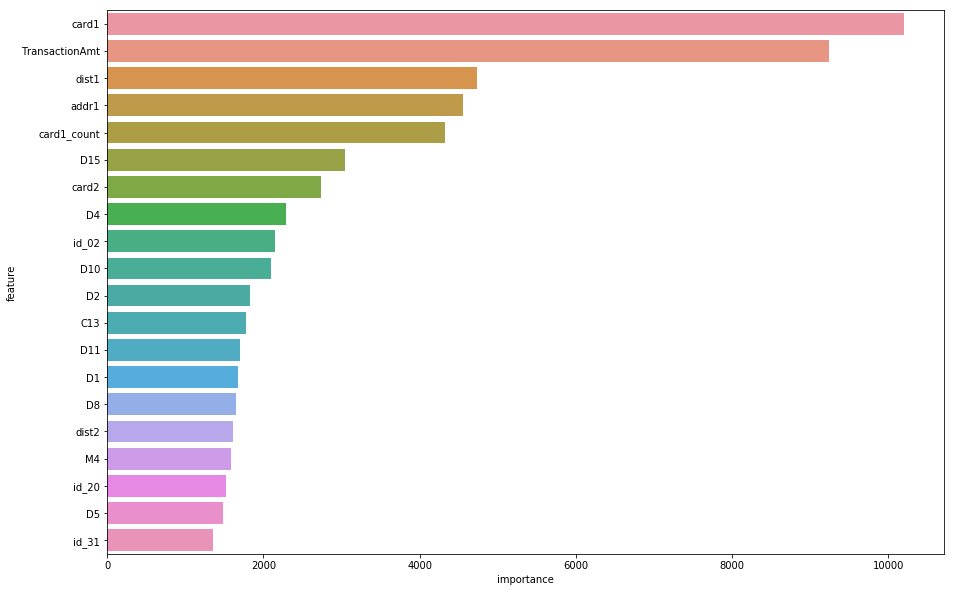

In [247]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [248]:
feature_importance_df[feature_importance_df['feature'] == 'V315_upper']

,feature,importance
432,V315_upper,45


# Dropping V313 and V314

## Splitting into train, val, and test

In [259]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID', 'V313', 'V314'], axis=1)
y = train['isFraud']

In [260]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [261]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [262]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [263]:
X_train.shape

(583369, 432)

In [264]:
X_val.shape

(7171, 432)

In [265]:
X_test = test.drop(['TransactionDT', 'TransactionID', 'V313', 'V314'], axis=1)

## Train LightGBM

In [266]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [267]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [268]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994758	valid_1's auc: 0.969977
[100]	training's auc: 0.999351	valid_1's auc: 0.978148
[150]	training's auc: 0.999889	valid_1's auc: 0.981359
[200]	training's auc: 0.999981	valid_1's auc: 0.982012
[250]	training's auc: 0.999996	valid_1's auc: 0.982711
[300]	training's auc: 0.999999	valid_1's auc: 0.983049
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.999999	valid_1's auc: 0.983049


## Predict on test sets

In [269]:
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)

In [270]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9830494664724111


## Bootstrapping

In [271]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

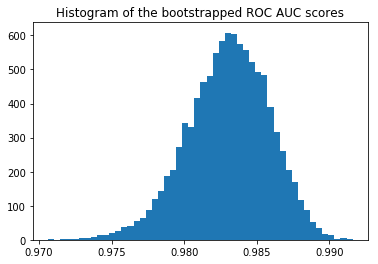

In [272]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [273]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.978 - 0.987]


In [274]:
sorted_scores.mean()

0.9830244408399372

In [275]:
sorted_scores.std()

0.0028141205601714234

# Save submission predictions

In [276]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('../submissions/submission_drop_V313_and_V314.csv', index=False)

## Feature importances

In [277]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [278]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

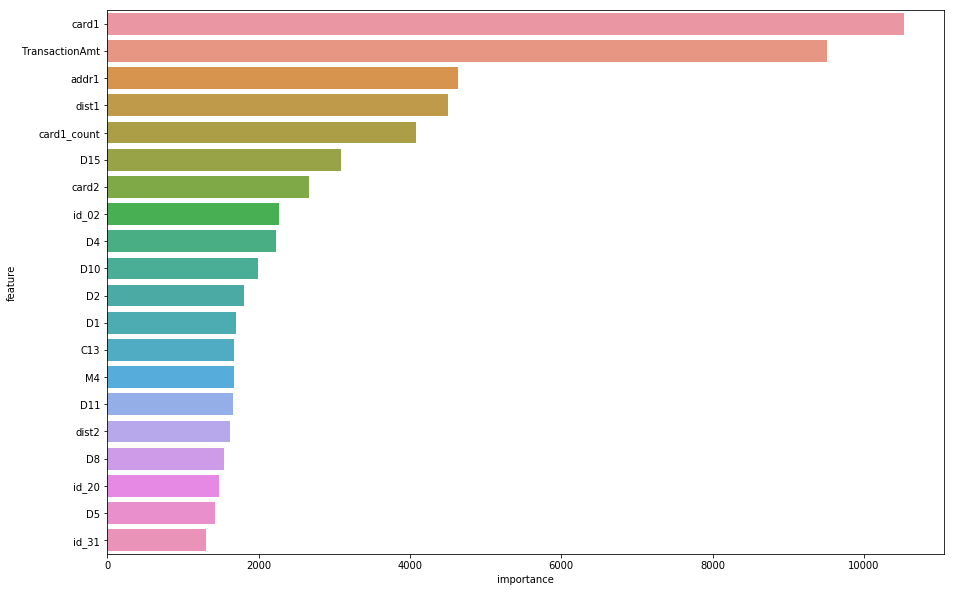

In [279]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [280]:
feature_importance_df

,feature,importance
2,card1,10534
0,TransactionAmt,9508
8,addr1,4641
10,dist1,4502
429,card1_count,4078
42,D15,3085
3,card2,2670
390,id_02,2271
31,D4,2236
37,D10,1989


# Dropping V313

## Splitting into train, val, and test

In [281]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID', 'V313'], axis=1)
y = train['isFraud']

In [282]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [283]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [284]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [285]:
X_train.shape

(583369, 433)

In [286]:
X_val.shape

(7171, 433)

In [287]:
X_test = test.drop(['TransactionDT', 'TransactionID', 'V313'], axis=1)

## Train LightGBM

In [288]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [289]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [290]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994603	valid_1's auc: 0.972379
[100]	training's auc: 0.999249	valid_1's auc: 0.977896
[150]	training's auc: 0.999875	valid_1's auc: 0.980311
[200]	training's auc: 0.999977	valid_1's auc: 0.980867
[250]	training's auc: 0.999995	valid_1's auc: 0.98139
Early stopping, best iteration is:
[236]	training's auc: 0.999993	valid_1's auc: 0.981477


## Predict on test sets

In [291]:
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)

In [292]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9814767183957352


## Bootstrapping

In [293]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

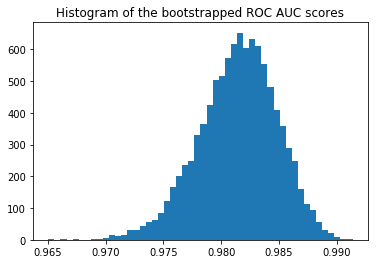

In [294]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [295]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.976 - 0.987]


In [296]:
sorted_scores.mean()

0.9814414836132488

In [297]:
sorted_scores.std()

0.0033745618833331973

# Save submission predictions

In [298]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('../submissions/submission_drop_V313.csv', index=False)

## Feature importances

In [299]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [300]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

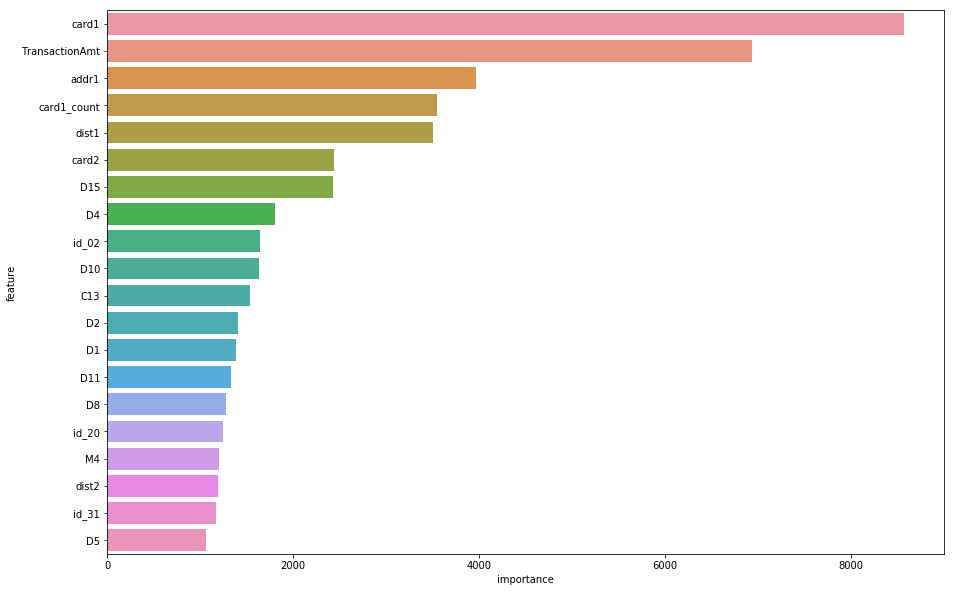

In [301]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [302]:
feature_importance_df

,feature,importance
2,card1,8579
0,TransactionAmt,6944
8,addr1,3970
430,card1_count,3546
10,dist1,3504
3,card2,2436
42,D15,2427
31,D4,1809
391,id_02,1640
37,D10,1633


# V307

In [48]:
train['V307'].isna().value_counts()

False    590528
True         12
Name: V307, dtype: int64

Text(0.5, 1.0, 'V307 distribution')

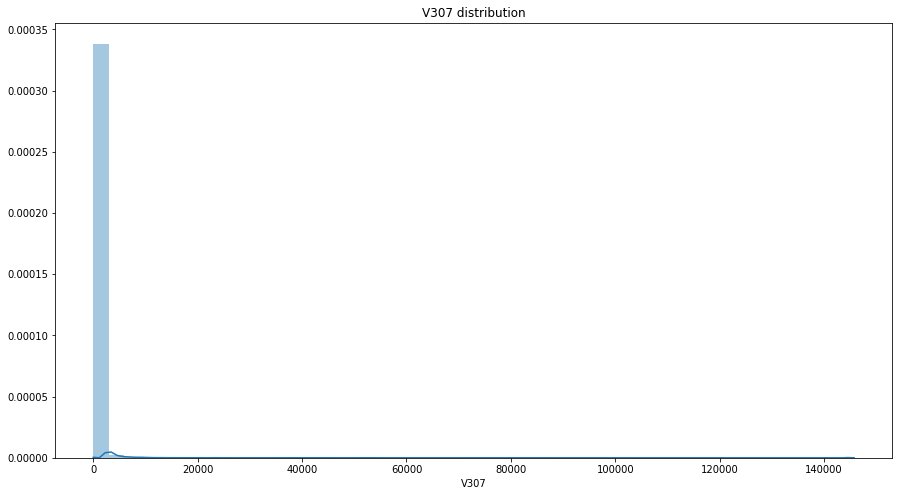

In [52]:
plt.figure(figsize=(15,8))
sns.distplot(train[train['V307'].notna()]['V307'])
plt.title('V307 distribution')

Pretty much all values at 0

In [99]:
correlations['V307'].sort_values(ascending=False).head(10)

V307    1.000000
V332    0.996515
V323    0.993701
V317    0.991723
V333    0.988320
V324    0.984823
V178    0.979735
V179    0.976457
V213    0.973727
V308    0.971069
Name: V307, dtype: float64

In [100]:
correlations[correlations['V307'].sort_values(ascending=False) >= 0.99]['V307'].index.tolist()[1:]

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


['V317', 'V323', 'V332']

Lot of highly correlated features. Let's just remove V307 for now

## Splitting into train, val, and test

In [111]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID', 'V313', 'V307'], axis=1)
y = train['isFraud']

In [112]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [113]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [114]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [115]:
X_train.shape

(583369, 430)

In [116]:
X_val.shape

(7171, 430)

In [117]:
X_test = test.drop(['TransactionDT', 'TransactionID', 'V313', 'V307'], axis=1)

## Train LightGBM

In [118]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [119]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [120]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.995005	valid_1's auc: 0.971421
[100]	training's auc: 0.999357	valid_1's auc: 0.976784
[150]	training's auc: 0.999893	valid_1's auc: 0.979251
[200]	training's auc: 0.999982	valid_1's auc: 0.979622
[250]	training's auc: 0.999996	valid_1's auc: 0.98051
[300]	training's auc: 0.999999	valid_1's auc: 0.980884
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.999999	valid_1's auc: 0.980884


## Predict on test sets

In [121]:
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [122]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.980883909963586


## Bootstrapping

In [123]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

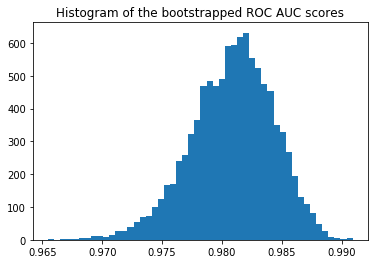

In [124]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [125]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.975 - 0.986]


In [126]:
sorted_scores.mean()

0.9808574106790102

In [127]:
sorted_scores.std()

0.0034398218011898437

## Feature importances

In [128]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [129]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

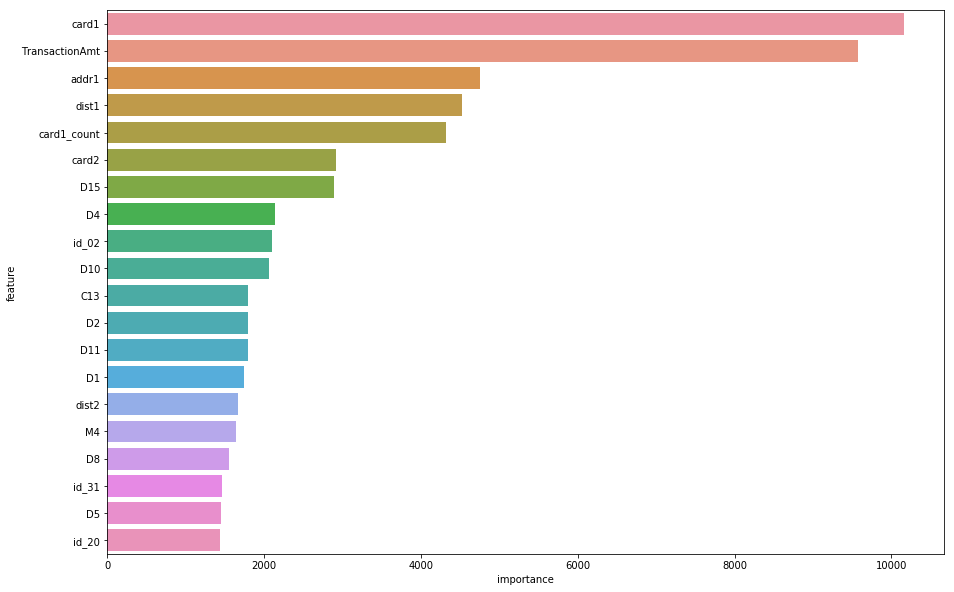

In [130]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [131]:
feature_importance_df

,feature,importance
2,card1,10164
0,TransactionAmt,9575
8,addr1,4752
10,dist1,4525
429,card1_count,4316
3,card2,2918
42,D15,2894
31,D4,2135
390,id_02,2107
37,D10,2062
